In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [13]:
# Read in iris_raw.csv
df = pd.read_csv("../data/customer_prepped.csv")
# Build X, y (target -> y), drop species if present
y = df["churn"]
# X = df.drop(columns=["churn",'product_id','sale_id', 'customer_id', 'price', 'total_value','feedback_text'], errors="ignore")
X = df.drop(columns=["tokens","churn",'product_id','sale_id','feedback_text','sentiment', 'sale_date', 'last_purchase_date','customer_id'], errors="ignore")


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define base random forest model before cross-validation
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Stratified cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("Stratified 5-Fold CV ROC AUC scores:", cv_scores)
print("Mean ROC AUC:", np.mean(cv_scores))

Stratified 5-Fold CV ROC AUC scores: [0.89494986 0.89782261 0.92300106 0.89035179 0.8940181 ]
Mean ROC AUC: 0.9000286856326856


Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Best CV AUC: 0.9483948607362033
Test Accuracy: 0.9641666666666666
Test ROC AUC: 0.9917618856517079

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1841
           1       0.98      0.86      0.92       559

    accuracy                           0.96      2400
   macro avg       0.97      0.93      0.95      2400
weighted avg       0.96      0.96      0.96      2400

avg_order_value              0.203793
days_since_last_purchase     0.184252
age                          0.147321
tenure_months                0.134490
freq_12m                     0.047659
freq_6m                      0.026736
sale_month                   0.023956
total_value                  0.021766
freq_3m                      0.018028
gender_Male                  0.017573
segment_Small Business       0.017320
region_W

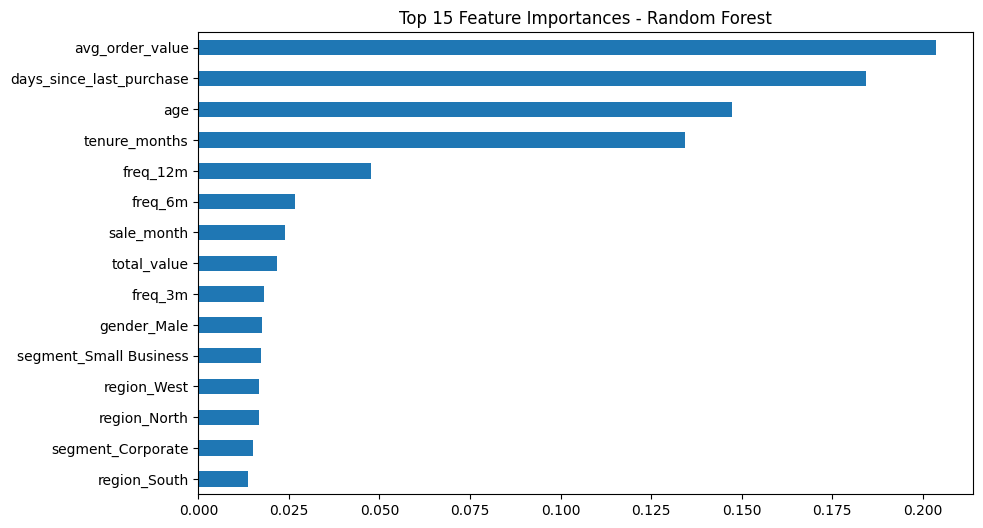

In [15]:
# hyperparameter tuning
param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

# randomized search
search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring="roc_auc",
    random_state=42, n_jobs=-1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)

# Best model after tuning
best_model = search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# evaluation metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("Test Accuracy:", acc)
print("Test ROC AUC:", roc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importances
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
print(importances)

# Plot feature importances
plt.figure(figsize=(10,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

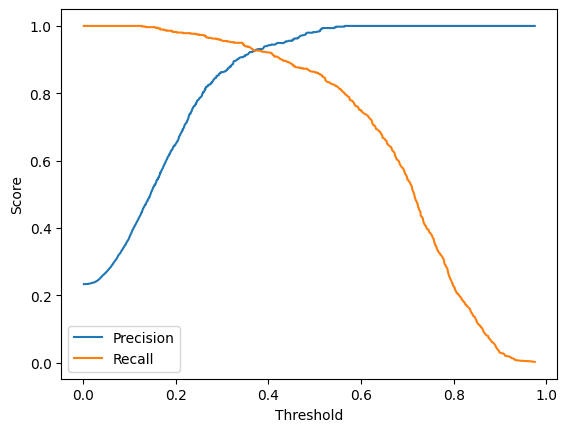

In [5]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Plot precision-recall trade-off
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


In [7]:
with open("../models/random_forest.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved to models/random_forest.pkl")

Model saved to models/random_forest.pkl
